# Quasi-Minimal Residual Method
### Eric Valentino and Kiran Shila


In essence, every large scale linear algebra problem boils down to the simple problem

\begin{equation}
Ax = b
\end{equation}

The naïve approach is to invert $A$ to then multiply by $b$. However, for large matrices this poses a problem. For Gauss-Jordan elimination, the time complexity of inversion is $O(n^3)$. Even the most optimized Coppersmith-Winograd algorithms have a complexity of $O(n^{2.373})$, which is not much better. So, other methods to solve $Ax=b$ have been developed. For systems that are tridiagonal, this problem can be solved in $O(n)$. Unfortunately, most problems are not tridiagonal problems. However, they can be close.

For solving partial differential equation problems, for example, the system is a modified multi-diagonal systems. Depending on the form, there may be a direct approach. While these direct approaches could faster than $O(n^3)$, they may be very memory intensive. Therefore, iterative methods have been developed.


## Iterative Methods

Simply put, an iterative method takes an $Ax=b$ problem, guesses $x$ and evaluates $Ax_{Guess}$. Then, based on the result of this, a new $X_{Guess}$ is created, and iterated until the solution reaches within some convergence value distance from $b$.

The choice of the next $x$ is dependent on the type of iterative method used.

## Conjugate Gradient
   One of the most widely used iterative methods is the conjugate gradient method as proposed by Hestenes and Stiefel. This method is a standard gradient-decent into the solution of $x$. To create a metric by which to test our convergence, one can note that the solution $x$ minimizes the quadratic

\begin{equation}
f(x) = \frac{1}{2}x^TAx-x^Tb
\end{equation}

This minimizer is unique as its second derivative is a positive-definite matrix

\begin{equation}
\nabla^2f(x) = A
\end{equation}

And due to the fact that the minimizer is minimized by $x$, its first derivative solves

\begin{equation}
\nabla f(x) = Ax-b
\end{equation}

Finally, we make a residual for the kth iteration as

\begin{equation}
r_k = b - Ax_k
\end{equation}

This residual is the negative gradient of f at $x_k$, so we decend in the direction of $r_k$. To create the next $x$ then, we find a direction vector $p$ such that $p$ is conjugate to all other directions we have traveled. We can calculate this with

\begin{equation}
p_k = r_k - \sum_{i<k}\frac{p_i^T A r_k}{p_i^T A p_i}p_i
\end{equation}

Finally, we take the next $k$ as

\begin{equation}
x_{k+1} = x_k + \alpha_k p_k
\end{equation}

## BiCojugate Gradient and QMR

Similar to the conjugate gradient method, the biconjugate gradient is an optimization for nonsymetric systems. The conjugate gradient method has been proven to be not suitable for such problems. As such, the BCG method is the preferred method for non-Hermitian linear systems. This is done by generating two sequences of residuals instead of one as 

\begin{align*}
r_k &= r_{k-1} - \alpha_k A p_{k} \\
\tilde{r}_k &= \tilde{r}_{k-1} - \alpha_k A^T \tilde{p}_{k}
\end{align*}

Visibly, we now create decent directions based on the conjugates of both $A$ and $A^T$. Obviously this will take twice as long as the typical conjugate gradient, but it is far more robust. 

In [15]:
using BenchmarkTools
using Plots
using LinearAlgebra
using SparseArrays
using Statistics

In [91]:
@enum ConvergenceReason MaximumIterations = 1  ConvergenceSatisfied = 2  MinimumEncountered = 3

function qmr(A, b; x0=zeros(length(b)) ,rtol= 1e-6, maxit=min(length(b),20) , M1 = I, M2 = I)
    # Lambda for right preconditioner
    M1m1x = x-> M1 \x
    M1tm1x = x-> M1' \x

    # Lamda for left preconditioner
    M2m1x = x-> M2 \x
    M2tm1x = x-> M2' \x

    # Lambda for multiplying by A
    Ax = x -> A*x
    Atx = x -> A'*x

    x = x0
    r = b - A*x
    bnorm = norm(b)
    res₀ = norm(r)
    res_vec = [res₀]
    vt = r
    y = M1m1x(vt)
    ρ₀ = norm(y)
    wt = r
    z = M2tm1x(wt)
    xi1 = norm(z)
    γ₀ = 1
    η₀ = -1
    flag = MaximumIterations

    # declaring things so they don't go out of scope in for loop
    ϵ₀ = 0
    v = nothing
    w = nothing
    p = nothing
    q = nothing
    p = nothing
    β₁ = nothing
    ρ₁ = nothing
    θ₀ = nothing
    θ₁ = nothing
    γ₁ = nothing
    η₁ = nothing
    d = nothing
    s = nothing
    res1 = nothing
    last_iter = nothing

    for iter=1:1:maxit
      ## If ρ₀ == 0 or xi1 == 0, method fails.
      v = vt / ρ₀
      y /= ρ₀
      w = wt / xi1
      z /= xi1
      δ₁ = z' * y   # If δ₁ == 0, method fails.
      yt = M2m1x(y)
      zt = M1tm1x(z)
      if (iter == 1)
        p = yt
        q = zt
      else# 2nd or higher
        p = yt - (xi1*δ₁/ϵ₀) * p
        q = zt - (ρ₀*δ₁/ϵ₀) * q
      end
      pt = Ax(p)
      ϵ₀ = (q' * pt)[1]          # If ϵ₀ == 0, method fails.
      β₁ = ϵ₀ / δ₁   # If β₁ == 0, method fails.
      vt = pt - β₁ * v
      y = M1m1x(vt)
      ρ₁ = norm(y)
      wt = Atx(q) - β₁ * w
      z = M2tm1x(wt)
      xi1 = norm(z)
      θ₁ = ρ₁ / (γ₀ * abs(β₁))
      γ₁ = 1 / sqrt(1 + θ₁^2)   # If γ₁ == 0, method fails.
      η₁ = -η₀ * ρ₀ * γ₁^2 / (β₁ * γ₀^2)

      if (iter == 1)
        d = η₁ * p
        s = η₁ * pt
      else
        d = η₁ * p + (θ₀*γ₁)^2 * d
        s = η₁ * pt + (θ₀ * γ₁)^2 * s
      end
      x += d
      r -= s

      res1 = norm(r) / bnorm
      push!(res_vec,res1)

      if (res1 < rtol)
        # Solver Converged with tolerance
        flag = ConvergenceSatisfied
        last_iter = iter
        break
      elseif (res₀ <= res1)
        # Local minimum found
        flag = MinimumEncountered
        last_iter = iter
        break
      end
      θ₀ = θ₁
      η₀ = η₁
      γ₀ = γ₁
      ρ₀ = ρ₁
    end

    relres = res1
  return x, flag, relres, last_iter, res_vec
end

qmr (generic function with 1 method)

# Testing on a small matrix

In order to verify that the QMR iterative solver is indeed solving $ Ax = b $, we can compare it to Julia's built-in backslash method, which is comparable to the MATLAB backslash

In [117]:
A = [1 2 3; 4 5 6;7 8 0]; b = [1,2,3] # 0 at end so matrix is not singular
A

3×3 Array{Int64,2}:
 1  2  3
 4  5  6
 7  8  0

In [18]:
b

3-element Array{Int64,1}:
 1
 2
 3

# Julia's built-in direct solution to the problem of $ Ax = b $ in this context is as follows:

In [19]:
A\b

3-element Array{Float64,1}:
 -0.33333333333333326
  0.6666666666666666 
 -0.0                

# Our QMR implementation produces the same output within $\epsilon$

In [36]:
x = qmr(A,b)[1]

3-element Array{Float64,1}:
 -0.3333333333333327    
  0.6666666666666682    
  1.0130785099704553e-15

# Performace

QMR, although naively implemented by us, should outperform direct computation of an inverse. Solving of $Ax=b$ by taking the inverse should perform worse in time and memory when compared to our solver.

In order to demonstrate this, we will plot the time it takes for QMR and the inverse to solve increasingly large matrices.

## Calculating the time and memory needed for qmr

In [21]:
sizes = floor.(Int32,exp10.(range(log10(5),stop=log10(200),length=10)))

qmr_times = []
qmr_mems = []
for n in sizes
    a = sprand(n, n, .1)
    A = a' * a + 100 *I # making diagonal dominate
    b = sum(Array(A) , dims = 2)
    d = @benchmark qmr(A, vec(b),rtol=1e-4)
    push!(qmr_times,mean(d.times))
    push!(qmr_mems,mean(d.memory))
end

In [22]:
inv_times = []
inv_mems = []
for n in sizes
    a = sprand(n, n, .1)
    A = a' * a + 100 *I # making diagonal dominate
    b = sum(Array(A) , dims = 2)
    d = @benchmark inv(Array(A))*b
    push!(inv_times,mean(d.times))
    push!(inv_mems,mean(d.memory))
end 

## Time Complexity Comparison

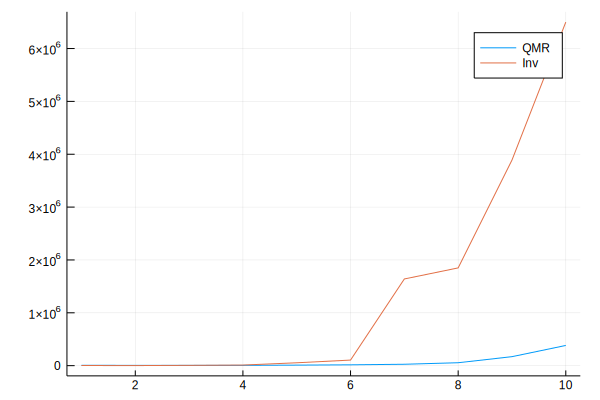

In [23]:
plot(qmr_times ,label="QMR")
plot!(inv_times ,label="Inv" )

## Memory Complexity Comparison

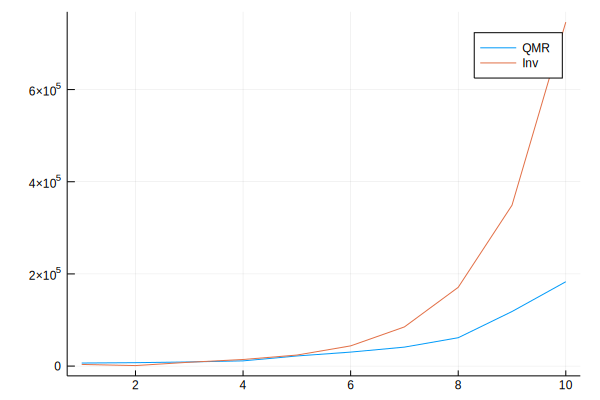

In [24]:
plot(qmr_mems ,label="QMR")
plot!(inv_mems ,label="Inv" )

## Performance with Preconditioning

In [100]:
n = 500
a = sprand(n, n, .1)
A = a' * a + 100 *I
b = sum(Array(A) , dims = 2)
x, flag, relres, last_iter, res_vec = qmr(A, vec(b),rtol=1e-8,maxit=100)
res_vec

9-element Array{Float64,1}:
 16229.391266795239       
     0.02182590850264535  
     0.0031553196986442078
     0.0003572470715974064
     4.2313332089125635e-5
     4.914338741557228e-6 
     6.198388907200305e-7 
     7.691401374504824e-8 
     8.603522368805572e-9 

In [101]:
# Do an exact LU decomp of a nearby matrix
F = lu(A + rand(n, n))
x, flag, relres, last_iter, res_vec = qmr(A, vec(b), M1 = F, rtol = 1e-8,maxit=100)
res_vec

8-element Array{Float64,1}:
 16229.391266795239       
     0.13630275065896233  
     0.0028135014628224908
     0.0002333319425001309
     1.0965934682790995e-5
     1.311453005731615e-6 
     1.9046661089463874e-7
     7.630817947732997e-9 

# Solving Poisson's Equation

In [25]:
# Non Linear
function nonlinear_s(args...)
    return 50*((args[1]/args[3])^2 + sin(10*args[2]/args[4]))
end

function non_homogeneous(args...)
    return 1.
end

non_homogeneous (generic function with 1 method)

In [26]:
function poisson_2d_dirichlet(source::Function,dirichlet::Function, L::Number,H::Number,numPoints::Tuple{Integer,Integer})
    # numPoints[1] is the "L" from my formulation
    Δx = L/numPoints[1] # Physical resolutions
    Δy = H/numPoints[2]

    # We are only solving the inner matrix, the outer edge is defined with the boundary condition
    problemSpace = (numPoints[1])*(numPoints[2])

    # Form the diagonals
    mainDiagonal = 0 => fill(-2,problemSpace)
    topDiagonal =  1 => fill(1,problemSpace-1)
    botDiagonal = -1 => fill(1,problemSpace-1)
    D_x = spdiagm(mainDiagonal,topDiagonal,botDiagonal)
    # Now place the zeros in the off-diagonals
    for i = numPoints[1]:numPoints[1]:problemSpace-1
        D_x[i,i+1] = 0
        D_x[i+1,i] = 0
    end
    # And fix the sparse matrix to clean the zeros
    dropzeros!(D_x)

    # Now to formulate D_y
    topDiagonal =  numPoints[1] => fill(1,problemSpace-(numPoints[2]))
    botDiagonal = -(numPoints[1]) => fill(1,problemSpace-(numPoints[2]))
    D_y = spdiagm(mainDiagonal,topDiagonal,botDiagonal)

    # Now make A
    A = (-(1/Δx^2).*D_x -(1/Δy^2).*D_y)

    # Now generate the source vector in 2D
    s = [source(x,y,numPoints[1],numPoints[2]) for x = 1:numPoints[1], y = 1:numPoints[2]]
    b = copy(s)

    # Apply the boundary conditions
    for j=1:numPoints[1]
        if j == 1
            # Top left
            b[1,j] = b[1,j] + dirichlet(2,1,numPoints[1],numPoints[2])/Δy^2 + dirichlet(1,2,numPoints[1],numPoints[2])/Δx^2
            # Bottom Left
            b[end,j] = b[end,j] + dirichlet(2,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2 + dirichlet(1,numPoints[2]+1,numPoints[1],numPoints[2])/Δx^2
        elseif j == numPoints[2]
            # Top Right
            b[1,j] = b[1,j] + dirichlet(numPoints[1]+1,1,numPoints[1],numPoints[2])/Δy^2 + dirichlet(numPoints[1]+2,2,numPoints[1],numPoints[2])/Δx^2
            # Bottom Right
            b[end,j] = b[end,j] + dirichlet(numPoints[1]+1,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2 + dirichlet(numPoints[1]+2,numPoints[2]+1,numPoints[1],numPoints[2])/Δx^2
        else
            # Top Edge
            b[1,j] = b[1,j] + dirichlet(j+1,1,numPoints[1],numPoints[2])/Δy^2

            # Bottom Edge
            b[end,j] = b[end,j] + dirichlet(j+1,numPoints[2]+2,numPoints[1],numPoints[2])/Δy^2
        end
    end

    # Now for left and right edge
    for i=2:numPoints[2]-1
        # Left Edge
        b[i,1] = b[i,1] + dirichlet(1,i+1,numPoints[1],numPoints[2])/Δx^2
        # Right Edge
        b[i,end] = b[i,end] + dirichlet(numPoints[1]+2,i+1,numPoints[1],numPoints[2])/Δx^2
    end

    # Reshape to 1D
    b = reshape(b,problemSpace)
    return A,b
end

poisson_2d_dirichlet (generic function with 1 method)

## Direct Solve Result

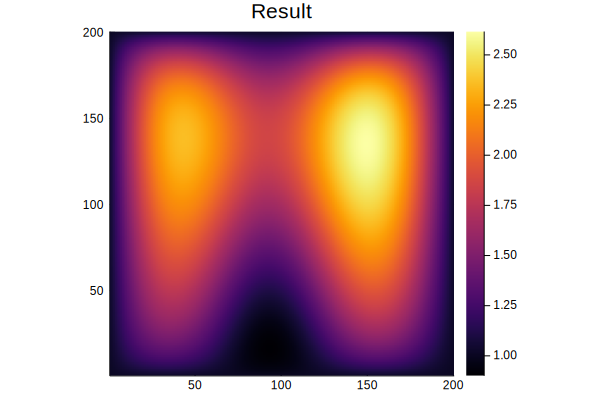

In [104]:
L = 1; H = 1; x_size = 200; y_size = 200
A,b = poisson_2d_dirichlet(nonlinear_s,non_homogeneous,L,H,(x_size,y_size))
x = A\b
heatmap(reshape(x,(x_size,y_size)),aspect_ratio=:equal,title="Result")

## Iterative Solve Result

In [28]:
@gif for it = 1:200
    heatmap(reshape(qmr(A,b,maxit=it)[1],(x_size,y_size)),aspect_ratio=:equal,title="Result")
end

┌ Info: Saved animation to 
│   fn = /Users/kiranshila/tmp.gif
└ @ Plots /Users/kiranshila/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/kiranshila/tmp.gif")

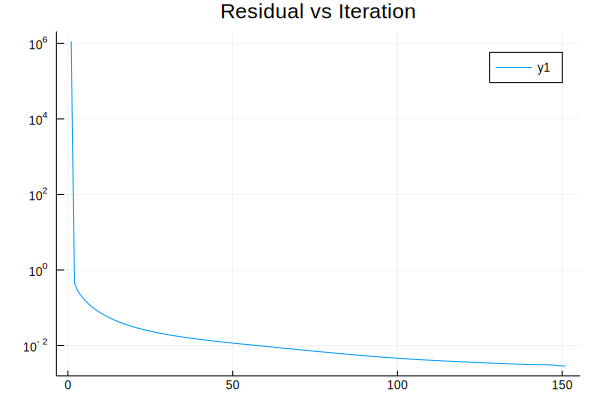

In [116]:
x, flag, relres, last_iter, res_vec = qmr(A,b,maxit=150)
plot(res_vec,yscale=:log10,title="Residual vs Iteration")